# Clasificador binario mejorado

Aqui realizaremos un analisis mas extenso sobre el clasificador binario utilizando el metodo de redes neuronales. Exploraremos sus posibles errores y como mejorar sus resultados hasta el maximo posible.

Los pasos a explorar son:
* introducir mas variables y quitar otras
* entrenar el clasificador para una sola estacion desde la cual tengamos muchos datos
* analizar los errores (casos de falsos negativos) e intentar entender por que ocurren
* buscar la configuracion optima para la estacion en cuestion.
* generar una funcion simple que permita llamar al clasificador y entregue la probabilidad de que ocurra la helada (no necesariamente decir "si" o "no")

#### la configuracion basica del clasificador consistira de 2 casos:
* recibe como inputs los datos medidos a las 14 y 20 horas del mismo dia
* recibe como inputs los datos medidos a las 20 horas del dia actual y el dia anterior

#### La arquitectura sera:
* salida de una neurona para clasificar binariamente
* funcion de activacion relu
* optimizador adagrad
* numero de hidden layers por evaluar


In [1]:
import pickle
import numpy as np
import sys
sys.path.append("../")
from regressor.regressor import Regressor, r_square, rmse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras.models import model_from_json
from sklearn.utils import resample
from sklearn.externals import joblib
from keras.callbacks import EarlyStopping
import keras

Using TensorFlow backend.
c:\programdata\miniconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def runMLP(X_train, X_test, y_train, y_test, verbose=True, weight=True):
    in_dim = X_train.shape[1]
    out_dim = 2
    estop = EarlyStopping(monitor="val_loss", patience=15, verbose=True, mode="min", min_delta=0.01)
    reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=3, layer_size=200, 
                loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], early_stopping=estop,
                out_activation="softmax")
    reg.build()
    y_train_class = keras.utils.to_categorical(y_train,2)
    y_test_class = keras.utils.to_categorical(y_test,2)
    
    class_weights = None
    if weight:
        class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), 
                                                y_train)
        class_weights = {0: class_weights[0], 1: class_weights[1]}
        print(class_weights)
#     class_weights = {0: 1, 1: 17.7}
#     cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}
#     val_sample_weights = class_weight.compute_sample_weight(cls_weight_dict, y_test._values)
    
    history = reg.fit(X_train, y_train_class, verbose=verbose, epochs=500, batch_size=400, 
                      validation_split=0.2, shuffle=True, class_weight=class_weights)
    if verbose:
        reg.plot_metrics()
    scores = reg.evaluate(X_test, y_test_class)
    return scores, reg

def cv_mlp(X, y, cv=10, weight=True):
    skf = StratifiedKFold(n_splits=cv)
    srcs = []
    for train_index, test_index in skf.split(X, y):
        print("iteration!...")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        outs, _ = runMLP(X_train, X_test, y_train, y_test, verbose=False, weight=weight)
        srcs.append(outs)
        keras.backend.clear_session()
    
    return srcs
    
def prob(outs):
    accs = []
    for o in outs:
        accs.append(o[1])
    
    print("mean: ", np.mean(accs), end=", ")
    print("median: ", np.median(accs), end=", ")
    print("std: ", np.std(accs), end=", ")

In [3]:
def load_data_small():
    pckl_in = open("../data/dias_limpiados3.pkl", "rb")
    pckl = pickle.load(pckl_in)
    hrs14 = 5
    hrs20 = 11
    hrs12 = 3
    hrs16 = 7
    K = 0
    data = np.full((pckl.shape[0], 17), None)
    for i in range(pckl.shape[0]):
        if i % 100 == 0:
            print(i, end="\r")
        line = pckl.iloc[i]
        k = 0
        for j in [hrs14, hrs20]:
            data[i][k] = line["Temp"][j]
            data[i][1+k] = line["PAtm"][j]
            data[i][2+k] = line["Hume"][j]
            data[i][3+k] = line["RadS"][j]
            data[i][4+k] = line["Vien"][j]
            k += 5
        data[i][k] = np.min(line["Temp"])
        data[i][k + 1] = int(line["Helada"])
        K = k + 2
    data = data[:,:K]
    return data, data[:,:-2], data[:,-1].astype(int)

In [4]:
data_single, X_single, y_single = load_data_small()
X_scaled_single = preprocessing.scale(X_single)
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_scaled_single, list(y_single), 
                                                                                test_size=0.2, stratify=y_single)
scores, reg_single = runMLP(X_train_single, X_test_single, y_train_single, y_test_single, verbose=False)
y_pred_single = (reg_single.predict(X_test_single)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_single, y_pred_single))
print(classification_report(y_test_single, y_pred_single))

W1217 21:47:54.941139  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1217 21:47:54.953826  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1217 21:47:54.955779  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1217 21:47:54.970419  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



W1217 21:47:55.085118  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1217 21:47:55.089023  4472 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1217 21:47:55.092926  4472 deprecation.py:323] From c:\programdata\miniconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 83,002
Trainable params: 83,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.5316656111462951, 1: 8.395}
Epoch 00088: early stopping
evaluando test
420/420 [==============================] - 0s 12us/step
    EVALUATION RESULTS :  
loss: 0.22
acc: 0.90
[[356  39]
 [  2  23]]
              precision    recall  f1-score   support

           

In [88]:
data, X, y = load_data_small()
X_scaled = preprocessing.scale(X)
outs_single = cv_mlp(X_scaled, y, cv=10)
prob(outs)

iteration!...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
{0: 0.5315315315315315, 1: 8.428571428571429}
Epoch 00039: early stopping
evaluando test
211/211 [==============================] - 0s 33us/step
    EVALUATION RESULTS :  
loss: 0.34
accuracy: 0.86
accuracy_1: 0.86
iteration!...
Model

Epoch 00044: early stopping
evaluando test
209/209 [==============================] - 0s 79us/step
    EVALUATION RESULTS :  
loss: 0.32
accuracy: 0.85
accuracy_1: 0.85
iteration!...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
{0: 0.5317951603826674, 1: 8.36283185840708}
Epoch 00040: early s

In [26]:
df = pd.read_csv("../data/coordenadas_estaciones.csv")
df.columns

Index(['codigo', 'region', 'estacion', 'latitud', 'longitud', 'msnm',
       'latitud_grad', 'latitud_min', 'latitud_seg', 'longitud_grad',
       'longitud_min', 'longitud_seg'],
      dtype='object')

In [27]:
df = df[['codigo', 'latitud', "msnm"]]
df.columns = ["code", "lat", "asnm"]
df.head()

,code,lat,asnm
0,180010,-18.50972,0
1,180020,-18.52055,218
2,34,-18.41361,0
3,38,-18.45222,532
4,43,-18.26389,3077


In [28]:
dataset_filename = "../data/processed/dataset1v2.csv"
data_df = pd.read_csv(dataset_filename)
cols = list(data_df.columns)
cols.pop(1)
data_df = data_df[cols]
data_df

,code,T_14,Hum_14,DVin_14,VVin_14,Prec_14,RadSol_14,PATM_14,T_20,Hum_20,DVin_20,VVin_20,Prec_20,RadSol_20,PATM_20,Target
0,13,7.2,66.7,61.4,0.0,0.0,146.0,1006.0,3.5,86.2,90.0,0.0,0.0,0.0,1004.0,1
1,13,14.0,48.6,315.7,0.0,0.0,246.3,1008.0,10.0,72.6,215.1,0.0,0.0,0.0,1014.0,0
2,13,8.6,82.4,228.0,0.0,0.0,118.5,1011.0,6.1,95.8,142.4,0.0,0.0,0.0,1012.0,0
3,13,6.0,84.9,53.2,0.0,0.2,53.6,1014.0,3.2,93.1,231.7,0.0,0.4,0.0,1020.0,0
4,13,0.8,89.7,240.3,0.0,0.0,39.6,1026.0,0.6,90.1,130.5,0.0,0.0,0.0,1028.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55809,450050,8.2,65.8,209.0,4.8,0.0,1.0,1010.0,8.3,91.5,305.0,0.2,0.0,131.0,1017.9,0
55810,450050,6.0,96.3,253.0,0.0,0.0,1.0,1016.9,9.6,74.9,254.0,2.0,0.0,153.0,1013.4,0
55811,450050,10.6,72.0,225.0,6.1,0.0,1.0,1014.3,9.1,90.3,51.0,3.9,0.6,22.0,1010.2,0
55812,450050,8.6,97.4,41.0,0.2,0.0,1.0,1009.6,11.3,90.1,250.0,3.7,0.4,12.0,1005.7,0


In [30]:
dataset_df = pd.merge(df, data_df, on="code")
dataset_df = dataset_df.drop(["code", "DVin_14", "DVin_20", "lat", "asnm"], axis=1)
dataset_df

,T_14,Hum_14,VVin_14,Prec_14,RadSol_14,PATM_14,T_20,Hum_20,VVin_20,Prec_20,RadSol_20,PATM_20,Target
0,24.4,53.0,2.2,0.0,738.0,1016.7,18.8,66.0,0.5,0.0,0.0,1018.0,0
1,23.6,54.0,2.7,0.0,699.0,1016.6,16.9,70.0,0.5,0.0,0.0,1018.0,0
2,22.4,54.0,2.2,0.0,709.0,1014.6,13.8,81.0,0.5,0.0,0.0,1016.1,0
3,22.3,58.0,2.2,0.0,709.0,1013.4,14.7,81.0,0.5,0.0,0.0,1014.8,0
4,21.4,62.0,2.2,0.0,709.0,1011.6,13.6,84.0,0.5,0.0,0.0,1013.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53952,15.0,57.9,0.4,0.0,214.0,933.3,9.7,79.8,0.2,0.0,1.0,934.7,0
53953,9.3,82.6,0.2,0.0,208.0,939.9,6.9,84.1,0.2,0.0,1.0,943.5,1
53954,16.2,33.2,0.7,0.0,529.0,940.9,5.6,69.3,0.7,0.0,1.0,939.8,1
53955,21.1,22.2,1.1,0.0,542.0,934.7,7.8,64.2,0.6,0.0,1.0,936.7,1


In [33]:
dddd = dataset_df.values
dddd[:,:-1].shape

(53957, 13)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 200)               2800      
_________________________________________________________________
dense_14 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_15 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 83,602
Trainable params: 83,602
Non-trainable params: 0
_________________________________________________________________
{0: 0.528361241676459, 1: 9.314846784635304}
Train on 34532 samples, validate on 8633 samples
Epoch 1/500
34532/34532 [==============================] - 3s 81us/step - loss: 0.6628 - acc: 0.7757 - val_loss: 0.6276 - val_acc: 0.7040
Epoch 2/500
34532/34532 [=============

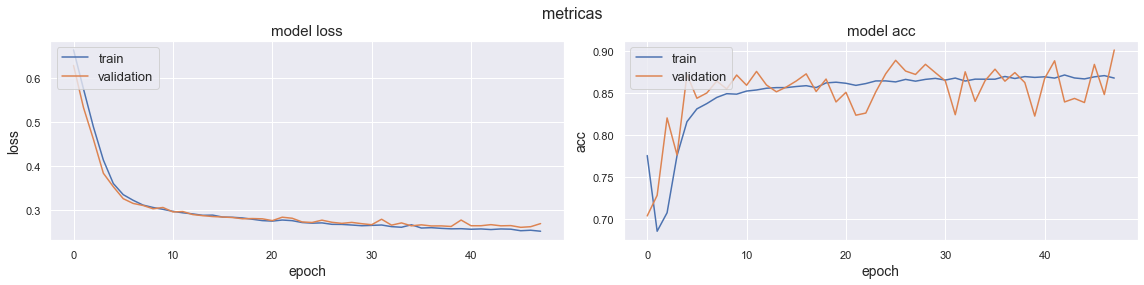

In [28]:
#normal weighted
data_normal = dataset_df.values
X_normal = data_normal[:,:-1]
y_normal = list(data_normal[:,-1].astype(int))
scaler_normal = MinMaxScaler()
scaler_normal.fit(X_normal)
X_scaled_normal = scaler_normal.transform(X_normal)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_scaled_normal, y_normal, 
                                                                                test_size=0.2, stratify=y_normal)
scores_normal, reg_normal = runMLP(X_train_normal, X_test_normal, y_train_normal, y_test_normal, verbose=True, weight=True)
y_pred_normal = (reg_normal.predict(X_test_normal)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_normal, y_pred_normal))
print(classification_report(y_test_normal, y_pred_normal))

In [39]:
ins = [27, 10.6, 58.2, 1.7, 0.0, 682.0, 1026.5, 5.8, 81.0, 0.5, 0.0, 0.0, 1028.6]
print(len(ins))
scaler_normal = MinMaxScaler()
scaler_normal.fit(X_normal)
scaled_in = scaler_normal.transform(np.array([ins]))
print(scaled_in)
reg_normal2.predict(scaled_in)

13
[[0.00877478 0.35555556 0.58433735 0.01188811 0.         0.48994253
  0.96362023 0.26116071 0.81488934 0.00316456 0.         0.
  0.98977919]]


array([[9.999337e-01, 6.629358e-05]], dtype=float32)

In [29]:
joblib.dump(scaler_normal, "./model/scaler.save") 

['./model/scaler.save']

In [42]:
model = reg_normal["model"]
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [46]:
ins = [27, 10.6, 58.2, 1.7, 0.0, 682.0, 1026.5, 5.8, 81.0, 0.5, 0.0, 0.0, 1028.6]
print(len(ins))
scaler_normal = MinMaxScaler()
scaler_normal.fit(X_normal)
scaled_in = scaler_normal.transform(np.array([ins]))
print(scaled_in)
loaded_model.predict(scaled_in)

13
[[0.00877478 0.35555556 0.58433735 0.01188811 0.         0.48994253
  0.96362023 0.26116071 0.81488934 0.00316456 0.         0.
  0.98977919]]


array([[0.04439975, 0.95560026]], dtype=float32)

In [16]:
reg_normal.save("class_binario_win")

saving model to disk ... done!


In [38]:
reg_normal2 = Regressor()
history = reg_normal2.load("class_binario_win")
y_pred_normal = (reg_normal.predict(X_test_normal)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_normal, y_pred_normal))
print(classification_report(y_test_normal, y_pred_normal))

loading model from disk ... done!
[[9208 1005]
 [  92  487]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     10213
           1       0.33      0.84      0.47       579

    accuracy                           0.90     10792
   macro avg       0.66      0.87      0.71     10792
weighted avg       0.95      0.90      0.92     10792



In [31]:
# normal weighted cross validation
data_normal = dataset_df[dataset_df.columns[1:]].to_numpy()
X_normal = data_normal[:,:-1]
y_normal = data_normal[:,-1].astype(int)
X_scaled_normal = preprocessing.scale(X_normal)
outs_normal = cv_mlp(X_scaled_normal, y_normal, cv=10)
prob(outs_normal)

iteration!...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 83,202
Trainable params: 83,202
Non-trainable params: 0
_________________________________________________________________
{0: 0.5283544413979196, 1: 9.316960859554873}
Epoch 00043: early stopping
evaluando test
5397/5397 [==============================] - 3s 489us/step
    EVALUATION RESULTS :  
loss: 0.26
acc: 0.86
iteration!...
______________________________________________

{0: 0.5283647046023283, 1: 9.313770617568085}
Epoch 00033: early stopping
evaluando test
5395/5395 [==============================] - 0s 35us/step
    EVALUATION RESULTS :  
loss: 0.29
acc: 0.86
iteration!...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 83,202
Trainable params: 83,202
Non-trainable params: 0
_________________________________________________________________
{0: 0.5283647046023283, 1: 9.313770617568085}
Epoch 00021: ea

In [9]:
prob(outs_normal)

mean:  0.8716582075098053, median:  0.8762044543953093, std:  0.020310167090213306, 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               3200      
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 402       
Total params: 84,002
Trainable params: 84,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.9997842037116962, 1: 1.000215889464594}
Train on 3706 samples, validate on 927 samples
Epoch 1/500
3706/3706 [==============================] - 0s 105us/step - loss: 0.6781 - acc: 0.6471 - val_loss: 0.6580 - val_acc: 0.7584
Epoch 2/500
3706/3706 [=================

3706/3706 [==============================] - 0s 9us/step - loss: 0.2374 - acc: 0.8994 - val_loss: 0.2590 - val_acc: 0.8997
Epoch 55/500
3706/3706 [==============================] - 0s 10us/step - loss: 0.2371 - acc: 0.8991 - val_loss: 0.2589 - val_acc: 0.9008
Epoch 56/500
3706/3706 [==============================] - 0s 8us/step - loss: 0.2362 - acc: 0.8999 - val_loss: 0.2587 - val_acc: 0.9029
Epoch 57/500
3706/3706 [==============================] - 0s 9us/step - loss: 0.2353 - acc: 0.9007 - val_loss: 0.2593 - val_acc: 0.9018
Epoch 58/500
3706/3706 [==============================] - 0s 8us/step - loss: 0.2347 - acc: 0.9007 - val_loss: 0.2592 - val_acc: 0.9018
Epoch 59/500
3706/3706 [==============================] - 0s 9us/step - loss: 0.2339 - acc: 0.9015 - val_loss: 0.2589 - val_acc: 0.9008
Epoch 60/500
3706/3706 [==============================] - 0s 8us/step - loss: 0.2333 - acc: 0.9021 - val_loss: 0.2590 - val_acc: 0.8986
Epoch 61/500
3706/3706 [==============================] - 0s

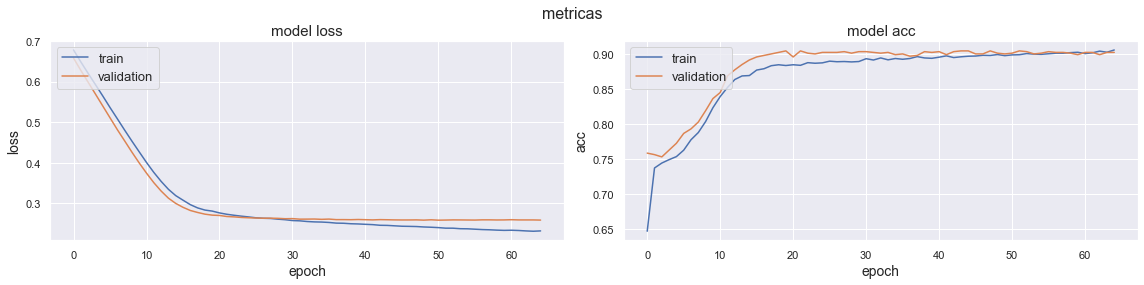

In [10]:
#downsampled

# Separate majority and minority classes
df_majority = dataset_df[dataset_df.Target==0]
df_minority = dataset_df[dataset_df.Target==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2896,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.Target.value_counts()


data_downsampled = df_downsampled[df_downsampled.columns[1:]].values
X_downsampled = data_downsampled[:,:-1]
y_downsampled = list(data_downsampled[:,-1].astype(int))
X_scaled_downsampled = preprocessing.scale(X_downsampled)
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X_scaled_downsampled, y_downsampled, test_size=0.2, stratify=y_downsampled)
scores_downsampled, reg_downsampled = runMLP(X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled, verbose=True, weight=True)
y_pred_downsampled = (reg_downsampled.predict(X_test_downsampled)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_downsampled, y_pred_downsampled))
print(classification_report(y_test_downsampled, y_pred_downsampled))

(43165, 17) (43165, 16) (53957, 17) (53957, 17)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 200)               3400      
_________________________________________________________________
dense_14 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_15 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 84,202
Trainable params: 84,202
Non-trainable params: 0
_________________________________________________________________
{0: 1.0, 1: 1.0}
Train on 65356 samples, validate on 16340 samples
Epoch 1/500
65356/65356 [==============================] - 1s 14us/step - loss: 0.4639 - acc: 0.7998 - val_loss: 0.2886 - val_acc: 0.8884
Epoch 2/500
65356

65356/65356 [==============================] - 1s 13us/step - loss: 0.1246 - acc: 0.9597 - val_loss: 0.1364 - val_acc: 0.9554
Epoch 54/500
65356/65356 [==============================] - 1s 12us/step - loss: 0.1218 - acc: 0.9606 - val_loss: 0.1326 - val_acc: 0.9568
Epoch 55/500
65356/65356 [==============================] - 1s 10us/step - loss: 0.1204 - acc: 0.9608 - val_loss: 0.1357 - val_acc: 0.9549
Epoch 56/500
65356/65356 [==============================] - 0s 8us/step - loss: 0.1189 - acc: 0.9616 - val_loss: 0.1324 - val_acc: 0.9567
Epoch 57/500
65356/65356 [==============================] - 1s 8us/step - loss: 0.1189 - acc: 0.9617 - val_loss: 0.1385 - val_acc: 0.9549
Epoch 58/500
65356/65356 [==============================] - 1s 8us/step - loss: 0.1186 - acc: 0.9619 - val_loss: 0.1348 - val_acc: 0.9554
Epoch 59/500
65356/65356 [==============================] - 0s 8us/step - loss: 0.1170 - acc: 0.9624 - val_loss: 0.1293 - val_acc: 0.9602
Epoch 60/500
65356/65356 [==================

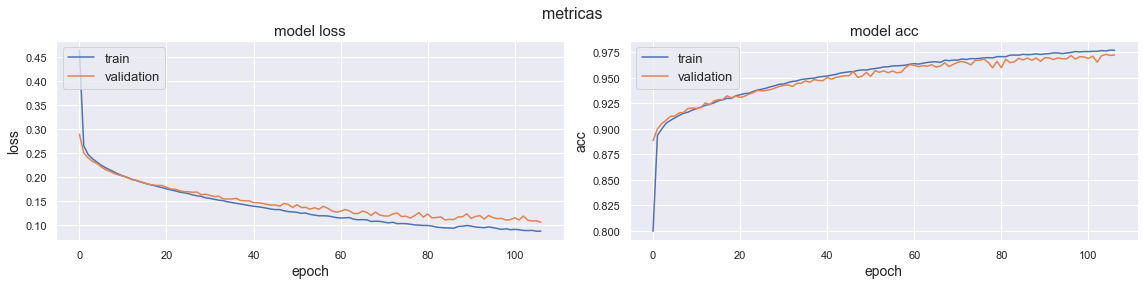

In [11]:
# upsampled

data0 = dataset_df.values
X0 = data0[:,:-1]
y0 = list(data0[:,-1].astype(int))
X_scaled0 = preprocessing.scale(X0)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_scaled0, y0, test_size=0.2, stratify=y0)
data_train0 = pd.DataFrame(X_train0)
data_train0["Target"] = y_train0
print(data_train0.shape, X_train0.shape, data0.shape, dataset_df.shape)


# Separate majority and minority classes
df_majority = data_train0[data_train0.Target==0]
df_minority = data_train0[data_train0.Target==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=40848,     # to match minority class
                                 random_state=1234) # reproducible results

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled.Target.value_counts()
# pd.DataFrame(df_minority_upsampled)


data_upsampled = df_upsampled.values
# X = data[:,:-1]
# y = list(data[:,-1].astype(int))
# X_scaled = preprocessing.scale(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)
X_train_upsampled = data_upsampled[:,:-1]
y_train_upsampled = data_upsampled[:,-1]
X_test_upsampled = X_test0
y_test_upsampled = y_test0
scores_upsampled, reg_upsampled = runMLP(X_train_upsampled, X_test_upsampled, y_train_upsampled, 
                                         y_test_upsampled, verbose=True)
y_pred_upsampled = (reg_upsampled.predict(X_test_upsampled)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_upsampled, y_pred_upsampled))
print(classification_report(y_test_upsampled, y_pred_upsampled))

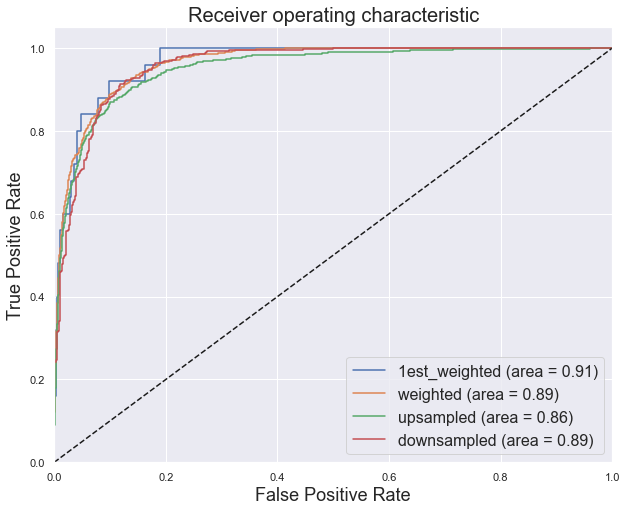

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
for classifier, label, y_tst, X_tst in zip([reg_single, reg_normal, reg_upsampled, reg_downsampled],
                                    ["1est_weighted", "weighted", "upsampled", "downsampled"],
                                    [y_test_single, y_test_normal, y_test_upsampled, y_test_downsampled], 
                                    [X_test_single, X_test_normal, X_test_upsampled, X_test_downsampled]):
    proba = classifier.predict(X_tst)
    class_pred = (proba[:,1] > 0.5).astype(int)
    cl_roc_auc = roc_auc_score(y_tst, class_pred)
    fpr, tpr, thresholds = roc_curve(y_tst, proba[:,1])
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (label,cl_roc_auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('Log_ROC')
plt.show()
    

In [13]:
xx = X_test_normal[np.where(np.array(y_test_normal, dtype=int) == 1)[0]]
proba = reg_normal.predict(xx)
proba[:,1][proba[:,1] > 0.5]

array([0.91152215, 0.9302907 , 0.99671125, 0.9934521 , 0.7907245 ,
       0.7995936 , 0.9953923 , 0.9704842 , 0.9699462 , 0.98970264,
       0.81399125, 0.7175487 , 0.9909837 , 0.7705493 , 0.99570364,
       0.8911073 , 0.9213994 , 0.9468946 , 0.9949209 , 0.90172744,
       0.9978448 , 0.98748183, 0.612639  , 0.9153471 , 0.9982414 ,
       0.8487801 , 0.99541014, 0.8445336 , 0.5134156 , 0.99663746,
       0.9915182 , 0.94392186, 0.71767086, 0.9710109 , 0.9628043 ,
       0.98946476, 0.95263016, 0.7547122 , 0.5173555 , 0.780591  ,
       0.9748487 , 0.9746062 , 0.9247199 , 0.9948496 , 0.9958643 ,
       0.99603266, 0.8083949 , 0.97307014, 0.95489526, 0.9889237 ,
       0.97995985, 0.995466  , 0.76231617, 0.8765977 , 0.93817204,
       0.9917841 , 0.9965837 , 0.97713464, 0.9390349 , 0.9966145 ,
       0.9841553 , 0.907211  , 0.91294026, 0.7366063 , 0.96081704,
       0.9819727 , 0.8125244 , 0.69108737, 0.6256381 , 0.94063085,
       0.6634529 , 0.8313891 , 0.98871803, 0.9940957 , 0.61981

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
W1217 21:50:01.387922  4472 legend.py:1282] No handles with labels found to put in legend.


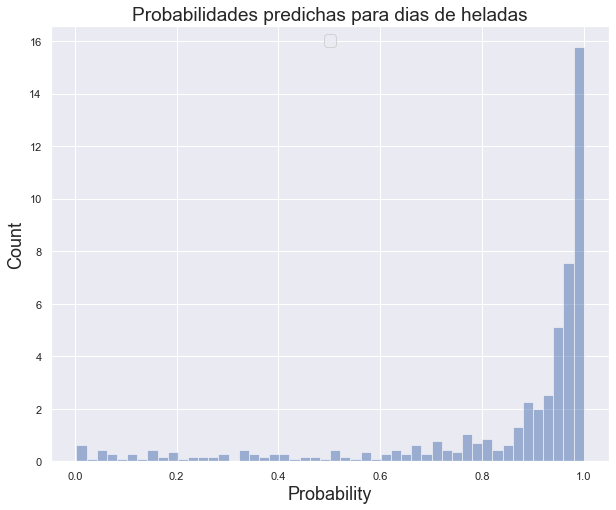

In [14]:
plt.figure(figsize=(10, 8))
# sns.distplot(svc.predict_proba(X_test)[:,0], hist=False, kde=True, bins=100, label="No-Helada")
proba = reg_normal.predict(xx)
plt.hist(proba[:,1], bins=50, normed=True, alpha=0.5, label="")
# sns.distplot(svc.predict_proba(X_test)[:,1], hist=False, kde=True, bins=100,label="Helada")
# plt.hist(proba[:,0], bins=50, normed=True, alpha=0.5, label="Pred. No-Helada (FP)")

plt.xlabel("Probability", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Probabilidades predichas para dias de heladas", fontsize=19)
plt.legend(fontsize=16, loc="upper center")

In [50]:
dftest = pd.DataFrame(np.load("../data/cleared2/dataset.npy", allow_pickle=True), columns=["code", "date", "time", "temp", "hum", "dir.vin", "vel.vin", "precip", 
           "rad.sol", "p.atm", "datetime+14hrs", "date+14hrs"])

In [51]:
dftest

,code,date,time,temp,hum,dir.vin,vel.vin,precip,rad.sol,p.atm,datetime+14hrs,date+14hrs
0,13,2010-06-11,12:15:00,6.2,70.2,179.9,0,0,125.5,1008,2010-06-12 02:15:00,2010-06-12
1,13,2010-06-11,12:30:00,6.4,64.8,138.4,0,0,181.7,1007,2010-06-12 02:30:00,2010-06-12
2,13,2010-06-11,12:45:00,6.4,64.9,96.9,0,0,159.5,1007,2010-06-12 02:45:00,2010-06-12
3,13,2010-06-11,13:00:00,6.9,62.1,121,0,0,328.2,1008,2010-06-12 03:00:00,2010-06-12
4,13,2010-06-11,13:15:00,7.1,62,47,0,0,195.2,1007,2010-06-12 03:15:00,2010-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...
5079140,450050,2010-06-29,07:30:00,7.7,73.7,234,3.9,0,1,1005.6,2010-06-29 21:30:00,2010-06-29
5079141,450050,2010-06-29,07:45:00,7,78.5,222,5,0,1,1006,2010-06-29 21:45:00,2010-06-29
5079142,450050,2010-06-29,08:00:00,8,70.9,206,5.2,0,1,1006.2,2010-06-29 22:00:00,2010-06-29
5079143,450050,2010-06-29,09:00:00,7.4,68.2,225,4.1,0,4,1007.1,2010-06-29 23:00:00,2010-06-29


In [10]:
dftest = pd.read_csv("../data/processed/backup_dffull.csv")

In [55]:
dftest.head()

,Codigo,Fecha,Hora,Temperatura,Humedad,Direccion de Viento,Velocidad de Viento,Precipitacion,Radiacion Solar,Presion Atmosferica,datetime,displaced_date
0,13,2010-06-11,12:15:00,6.2,70.2,179.9,0.0,0.0,125.5,1008.0,2010-06-11 12:15:00,2010-06-10
1,13,2010-06-11,12:30:00,6.4,64.8,138.4,0.0,0.0,181.7,1007.0,2010-06-11 12:30:00,2010-06-10
2,13,2010-06-11,12:45:00,6.4,64.9,96.9,0.0,0.0,159.5,1007.0,2010-06-11 12:45:00,2010-06-10
3,13,2010-06-11,13:00:00,6.9,62.1,121.0,0.0,0.0,328.2,1008.0,2010-06-11 13:00:00,2010-06-10
4,13,2010-06-11,13:15:00,7.1,62.0,47.0,0.0,0.0,195.2,1007.0,2010-06-11 13:15:00,2010-06-10


In [11]:
df = pd.read_csv("../data/coordenadas_estaciones.csv")
cols = list(df.columns)
cols[0] = "Codigo"
df.columns = cols
df

,Codigo,region,estacion,latitud,longitud,msnm,latitud_grad,latitud_min,latitud_seg,longitud_grad,longitud_min,longitud_seg
0,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,14,53
1,180020,ARICA Y PARINACOTA,AZAPA2,-18.52055,-70.24805,218,-18,31,14,-70,14,53
2,34,ARICA Y PARINACOTA,COLONIA JFLLUTA BAJO,-18.41361,-70.20611,0,-18,24,49,-70,12,22
3,38,ARICA Y PARINACOTA,PUROCHILE LLUTA MEDIO,-18.45222,-70.06722,532,-18,27,8,-70,4,2
4,43,ARICA Y PARINACOTA,SOCOROMA,-18.26389,-69.60778,3077,-18,15,50,-69,36,28
...,...,...,...,...,...,...,...,...,...,...,...,...
148,320075,VALPARAISO,PUTAENDO,-32.59361,-70.72611,878,-32,35,37,-70,43,34
149,320100,VALPARAISO,QUILLOTA,-32.89250,-71.20667,142,-32,53,33,-71,12,24
150,320065,VALPARAISO,RINCONADA,-32.83694,-70.69250,726,-32,50,13,-70,41,33
151,320070,VALPARAISO,SAN FELIPE,-32.80000,-70.70028,701,-32,47,60,-70,42,1


In [12]:
dftest = pd.merge(df, dftest, on="Codigo")

In [67]:
dftest.head()

,Codigo,region,estacion,latitud,longitud,msnm,latitud_grad,latitud_min,latitud_seg,longitud_grad,...,Hora,Temperatura,Humedad,Direccion de Viento,Velocidad de Viento,Precipitacion,Radiacion Solar,Presion Atmosferica,datetime,displaced_date
0,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,...,16:45:00,23.7,53.0,0.0,0.5,0.0,383.0,1014.0,2009-05-28 16:45:00,2009-05-27
1,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,...,17:00:00,22.8,55.0,0.0,0.5,0.0,286.0,1014.5,2009-05-28 17:00:00,2009-05-27
2,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,...,17:15:00,22.6,56.0,0.0,0.9,0.0,283.0,1014.5,2009-05-28 17:15:00,2009-05-27
3,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,...,17:30:00,22.1,57.0,0.0,0.9,0.2,172.0,1014.4,2009-05-28 17:30:00,2009-05-27
4,180010,ARICA Y PARINACOTA,AZAPA1,-18.50972,-70.24805,0,-18,30,35,-70,...,17:45:00,21.7,58.0,0.0,0.9,0.0,37.0,1014.6,2009-05-28 17:45:00,2009-05-27


In [13]:
temp = dftest["Temperatura"]
hum = dftest["Humedad"]
vvin = dftest["Velocidad de Viento"]
prec = dftest["Precipitacion"]
radsol = dftest["Radiacion Solar"]
patm = dftest["Presion Atmosferica"]
asnm = dftest["msnm"]
lat = dftest["latitud"]
lon = dftest["longitud"]


In [14]:
import matplotlib.pyplot as plt

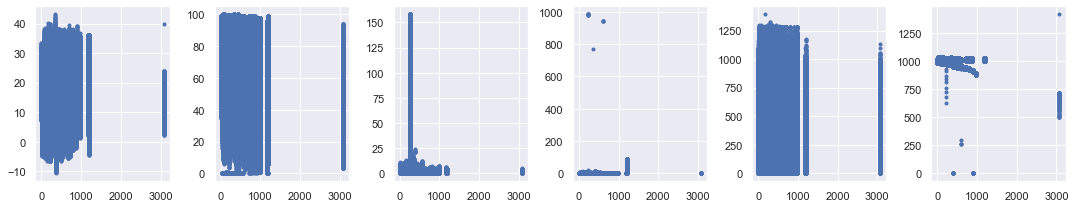

In [21]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
ax[0].plot(asnm, temp, '.')
ax[0].set_xlabel("ASNM", fontsize=14)
ax[0].set_ylabel("temp", fontsize=14)

ax[1].plot(asnm, hum, ".")
ax[1].set_xlabel("ASNM", fontsize=14)
ax[1].set_ylabel("hum.", fontsize=14)

ax[2].plot(asnm, vvin, ".")
ax[2].set_xlabel("ASNM", fontsize=14)
ax[2].set_ylabel("v.vien.", fontsize=14)

ax[3].plot(asnm, prec, ".")
ax[3].set_xlabel("ASNM", fontsize=14)
ax[3].set_ylabel("precip.", fontsize=14)

ax[4].plot(asnm, radsol, ".")
ax[4].set_xlabel("ASNM", fontsize=14)
ax[4].set_ylabel("rad. sol", fontsize=14)

ax[5].plot(asnm, patm, ".")
ax[5].set_xlabel("ASNM", fontsize=14)
ax[5].set_ylabel("p. ATM.", fontsize=14)

plt.tight_layout()

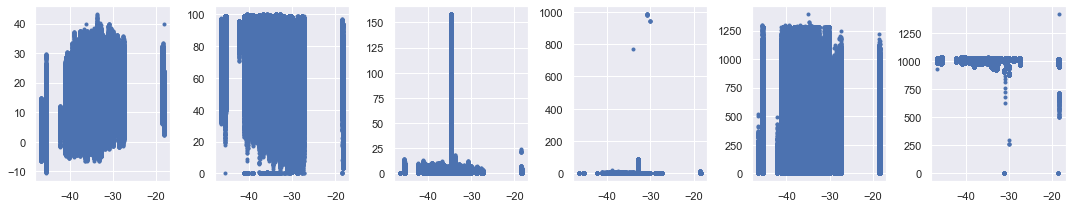

In [22]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
ax[0].plot(lat, temp, '.')
ax[0].set_xlabel("ASNM", fontsize=14)
ax[0].set_ylabel("temp", fontsize=14)

ax[1].plot(lat, hum, ".")
ax[1].set_xlabel("ASNM", fontsize=14)
ax[1].set_ylabel("hum.", fontsize=14)

ax[2].plot(lat, vvin, ".")
ax[2].set_xlabel("ASNM", fontsize=14)
ax[2].set_ylabel("v.vien.", fontsize=14)

ax[3].plot(lat, prec, ".")
ax[3].set_xlabel("ASNM", fontsize=14)
ax[3].set_ylabel("precip.", fontsize=14)

ax[4].plot(lat, radsol, ".")
ax[4].set_xlabel("ASNM", fontsize=14)
ax[4].set_ylabel("rad. sol", fontsize=14)

ax[5].plot(lat, patm, ".")
ax[5].set_xlabel("ASNM", fontsize=14)
ax[5].set_ylabel("p. ATM.", fontsize=14)

plt.tight_layout()

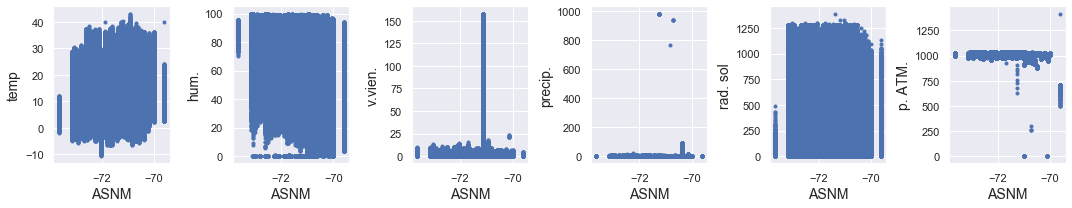

In [32]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
ax[0].plot(lon, temp, '.')
ax[0].set_xlabel("ASNM", fontsize=14)
ax[0].set_ylabel("temp", fontsize=14)

ax[1].plot(lon, hum, ".")
ax[1].set_xlabel("ASNM", fontsize=14)
ax[1].set_ylabel("hum.", fontsize=14)

ax[2].plot(lon, vvin, ".")
ax[2].set_xlabel("ASNM", fontsize=14)
ax[2].set_ylabel("v.vien.", fontsize=14)

ax[3].plot(lon, prec, ".")
ax[3].set_xlabel("ASNM", fontsize=14)
ax[3].set_ylabel("precip.", fontsize=14)

ax[4].plot(lon, radsol, ".")
ax[4].set_xlabel("ASNM", fontsize=14)
ax[4].set_ylabel("rad. sol", fontsize=14)

ax[5].plot(lon, patm, ".")
ax[5].set_xlabel("ASNM", fontsize=14)
ax[5].set_ylabel("p. ATM.", fontsize=14)

plt.tight_layout()